## Cross-Selling - Stones <br>
### Developers:
1. Cristiane Rodrigues da Silva
2. Fernando Rodrigues da Silva
3. Maycon Cypriano Batestin


<p> Fonte de dados: https://drive.google.com/open?id=1RhBcilf-PuP4Zj1XsYmhN1sV_yk2kVQK&usp=drive_fs


---

# Objetivo

1. Criar um sistema de recomendação com base nas transações de máquinas Stone
2. Ajudar a prever quais categorias de compras um cliente pode realizar de acordo com suas transações.
3. Oferecer cross-selling baseado nas compras.

# Bibliotecas

In [50]:

import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import NearestNeighbors
import joblib


# Obtendo o Dataset

In [51]:
# arquivos em parquet

data_movimento = pd.read_parquet('/content/dataset/hackathon_stone_brasa_banking_data.parquet')
data_vendas = pd.read_parquet('/content/dataset/hackathon_stone_brasa_sales_data.parquet')
mcc = pd.read_parquet('/content/dataset/mcc.parquet')


## Análise Exploratória

In [52]:
print(f"""
{data_movimento.info()}

{data_vendas.info()}

{mcc.info()}

""")


<class 'pandas.core.frame.DataFrame'>
Index: 66189 entries, 0 to 66188
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   document_id            66189 non-null  int64         
 1   date_time              66189 non-null  datetime64[us]
 2   value                  66189 non-null  float64       
 3   counterparty_document  66189 non-null  int64         
 4   type                   66189 non-null  object        
dtypes: datetime64[us](1), float64(1), int64(2), object(1)
memory usage: 3.0+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 264933 entries, 0 to 266969
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   document_id  264933 non-null  int64         
 1   date_time    264933 non-null  datetime64[us]
 2   value        264933 non-null  float64       
 3   card_number  264933 non-null  object       

##### Inferência
1. Com base nas observações acima para o nosso sistema de cross-selling, decidimos optar pelo uso combinado do data_vendas e do mcc que contem as caracteristicas, o preço, unidades federativas e unidades fisicas daquilo que consideramos importante para o modelo de machine learning

In [53]:
data_vendas = data_vendas[['date_time', 'value',	'type',	'mcc', 'state']]
df = pd.merge(data_vendas, mcc, on='mcc', how='left')
df['description'] = df['edited_description']
df = df[['date_time', 'value', 'type', 'state', 'description']]



In [54]:
df.isna().sum()

,0
date_time,0
value,0
type,0
state,0
description,0


In [55]:
#exportando para uso em dataviz
df.to_csv('/content/dados_consolidados.csv')

# Analise de Dados

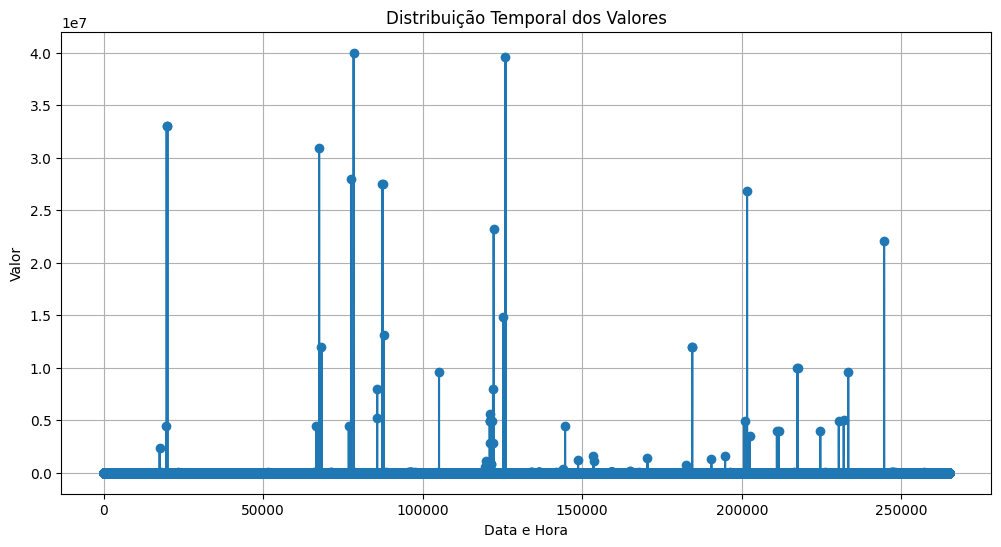

In [56]:
#Distribuição Temporal dos Valores


plt.figure(figsize=(12, 6))
plt.plot(df.index, df['value'], marker='o', linestyle='-')
plt.title('Distribuição Temporal dos Valores')
plt.xlabel('Data e Hora')
plt.ylabel('Valor')
plt.grid(True)
plt.show()

#### Inferência:
1. Os valores apresentam uma variabilidade significativa ao longo do tempo. Há períodos de valores altos, baixos e períodos de mudança rápida.
2. Não parece haver uma tendência consistente de alta ou baixa nos valores.
3. Embora o período de tempo seja relativamente curto, pode haver uma sugestão de sazonalidade, especialmente se os dados estiverem relacionados a fenômenos do mundo real. No entanto, mais pontos de dados seriam necessários para confirmar isso.

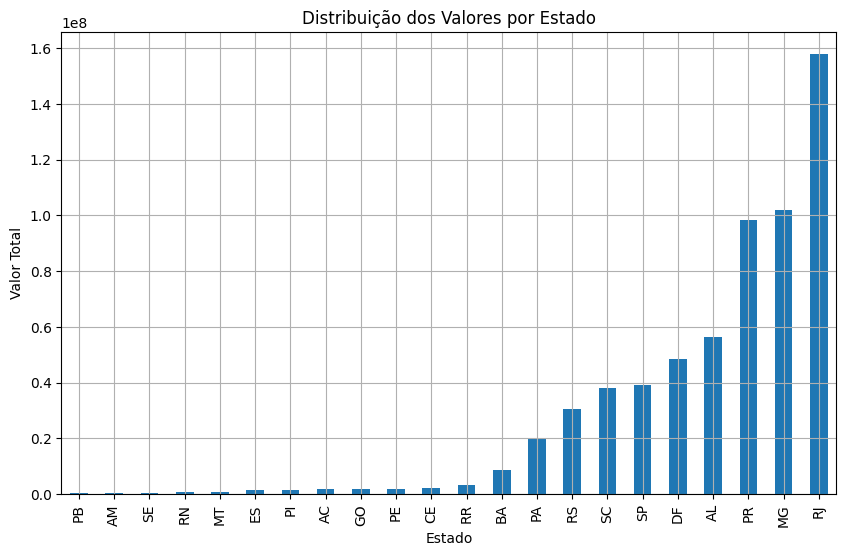

In [57]:
#Distribuição dos Valores por Estado:

state_summary = df.groupby('state')['value'].sum().sort_values()

plt.figure(figsize=(10, 6))
state_summary.plot(kind='bar')
plt.title('Distribuição dos Valores por Estado')
plt.xlabel('Estado')
plt.ylabel('Valor Total')
plt.grid(True)
plt.show()

#### Inferência
1. Percebemos que a maioria das vendas analisadas se concentra no estado do RJ, e o estado com menor uso é Paraiba. Os fatores podem ter relação com desenvolvimento do estado, em sua visao macroeconomica.

In [68]:
#criando as regiões do brasil
region_mapping = {
    'SP': 'Sudeste', 'RJ': 'Sudeste', 'MG': 'Sudeste', 'ES': 'Sudeste',
    'GO': 'Centro-Oeste', 'MT': 'Centro-Oeste', 'DF': 'Centro-Oeste',
    'RS': 'Sul', 'SC': 'Sul', 'PR': 'Sul',
    'CE': 'Nordeste', 'RN': 'Nordeste', 'PB': 'Nordeste', 'PE': 'Nordeste',
    'BA': 'Nordeste', 'MA': 'Nordeste', 'PI': 'Nordeste', 'SE': 'Nordeste',
    'AC': 'Norte', 'AM': 'Norte', 'PA': 'Norte', 'RO': 'Norte', 'RR': 'Norte', 'AP': 'Norte'
}

# Adicionar a coluna 'region' ao DataFrame
df['region'] = df['state'].map(region_mapping)

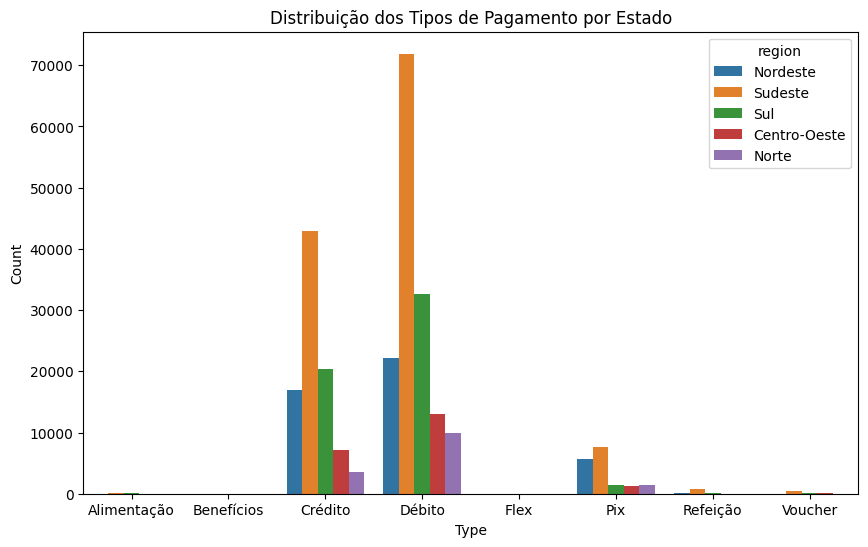

In [70]:
#Distribuição dos Tipos de Pagamento por Estado:

type_state_count = df.groupby(['type', 'region']).size().reset_index(name='count')

# Plotando o gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x='type', y='count', hue='region', data=type_state_count)
plt.title('Distribuição dos Tipos de Pagamento por Estado')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

### Inferência
1. Percebemos que a maioria das vendas analisadas se concentra no estado do RJ, e esse tipo de cartão usado, é débito, tendo uma rivalidade quase que central com crédito. O tipo de  menos usado é beneficios.

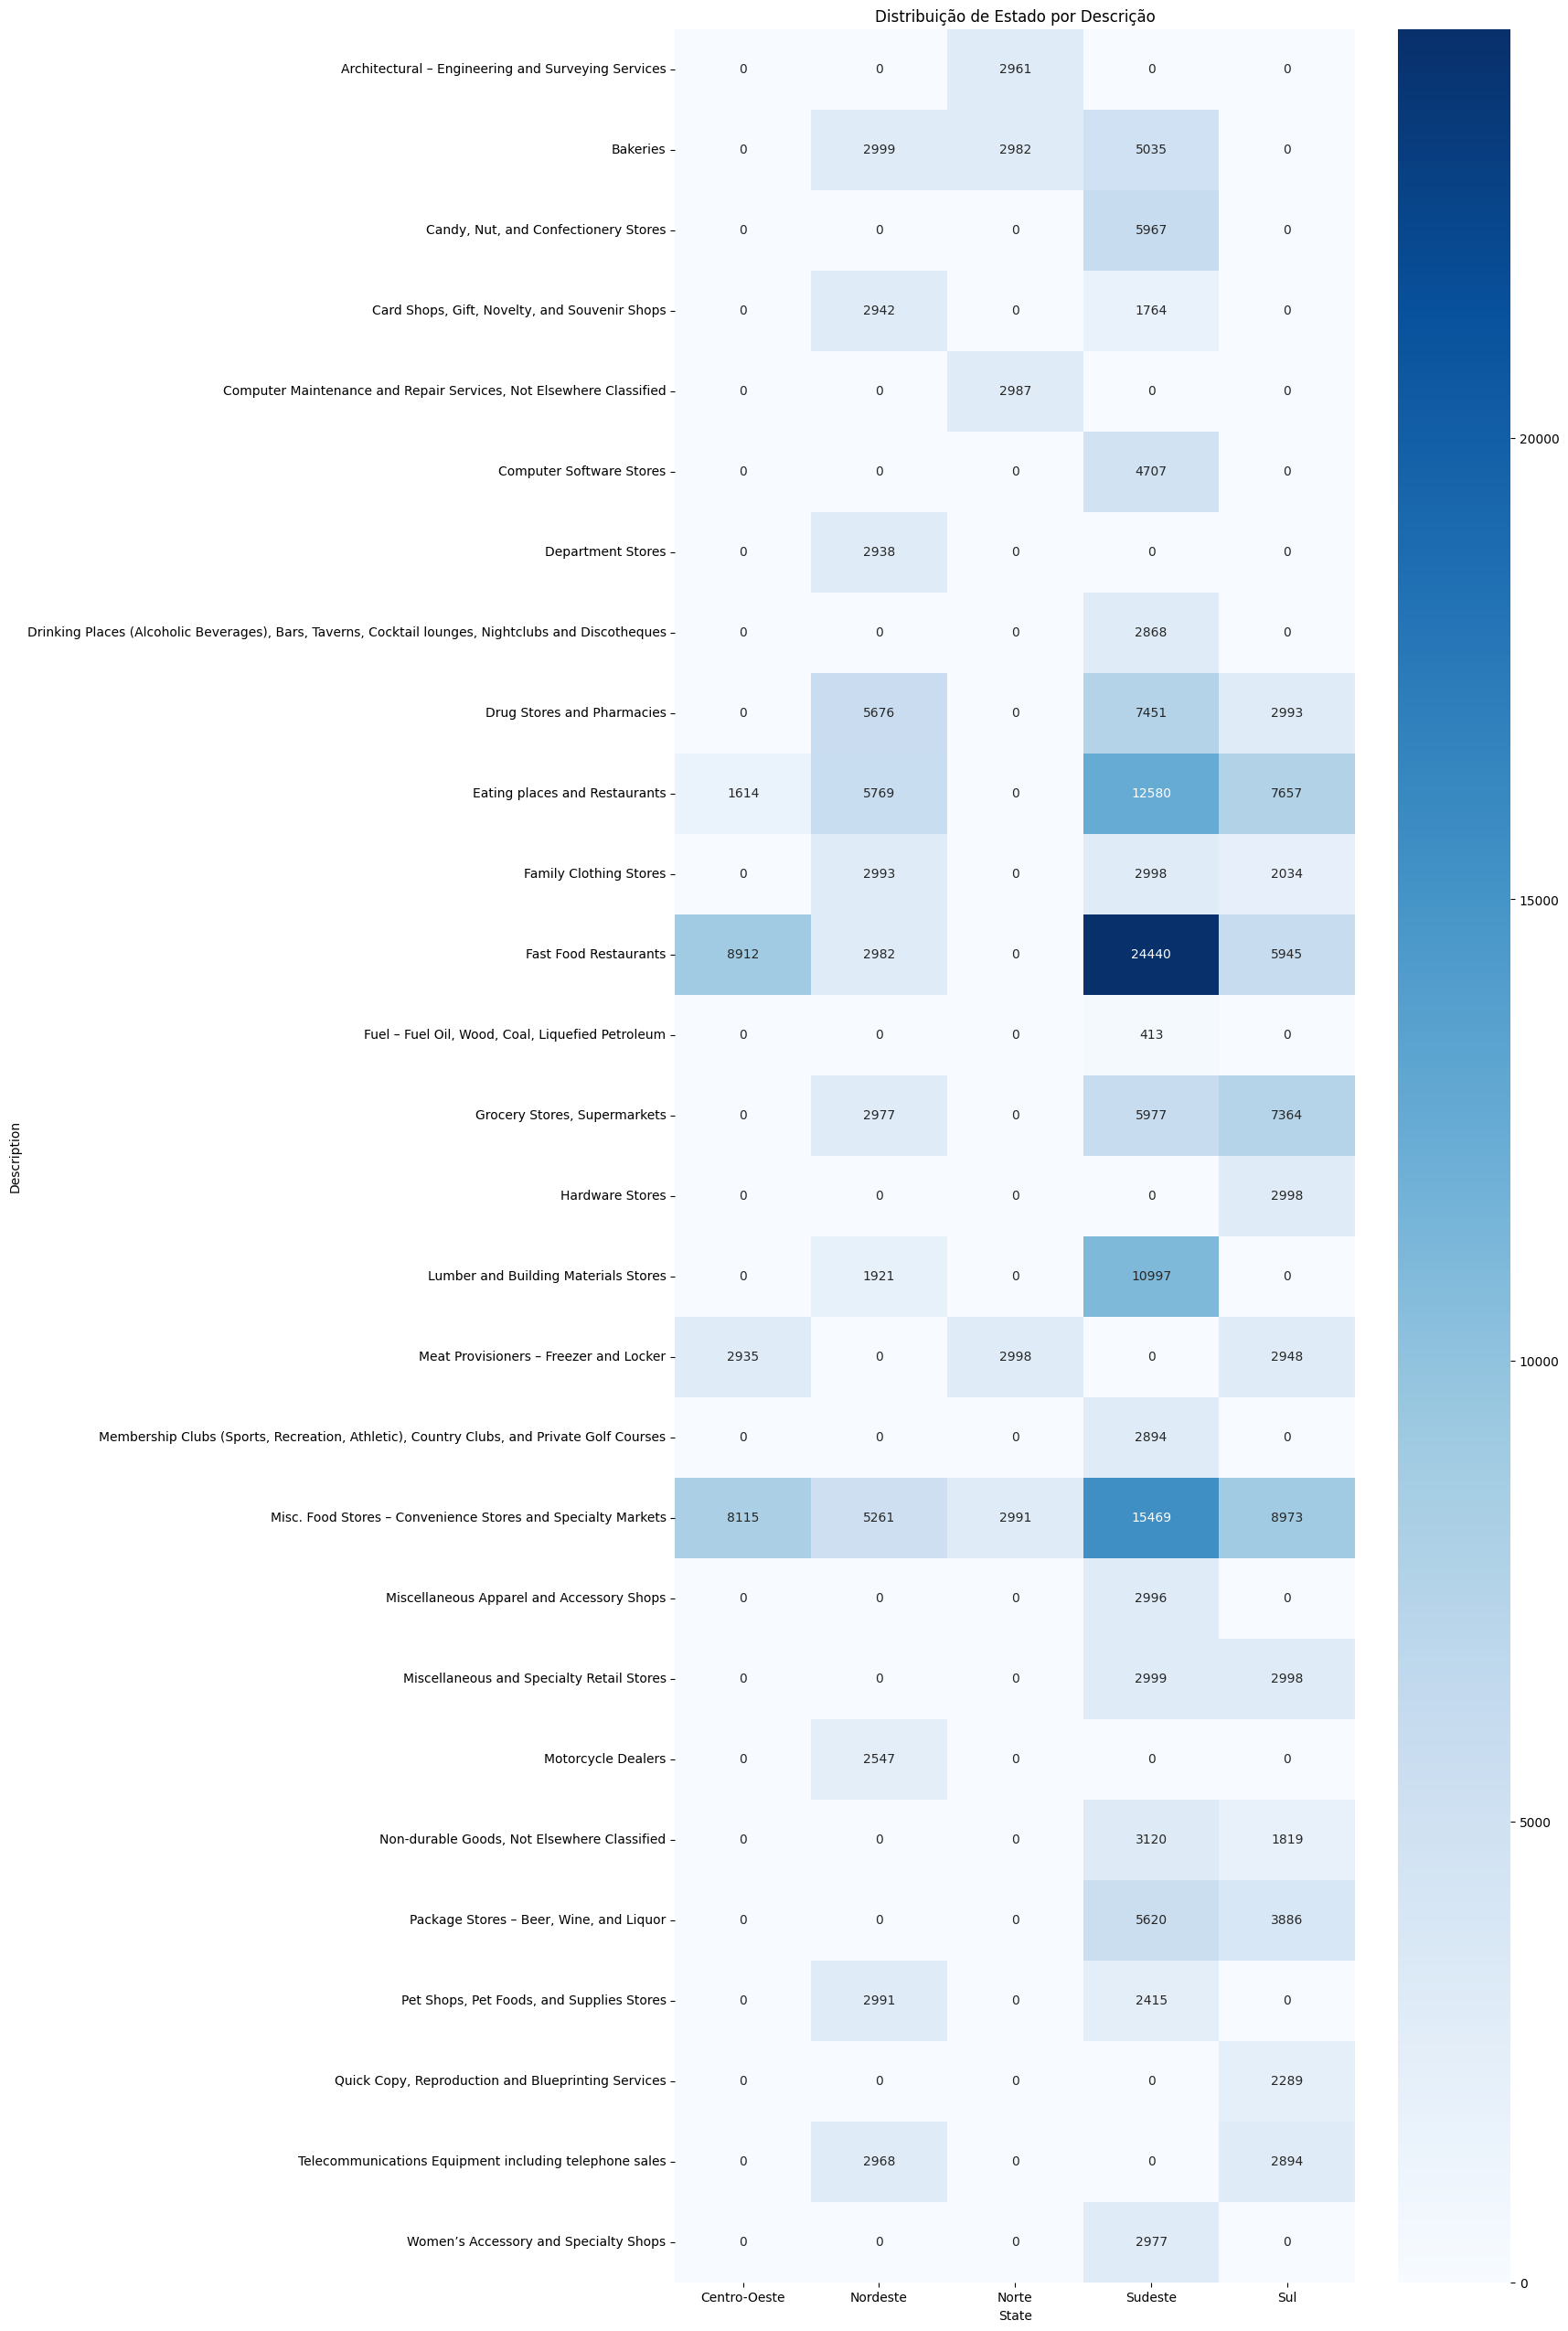

In [80]:
description_state_count = df.groupby(['description', 'region']).size().reset_index(name='count')

# Plotando o gráfico
heatmap_data = df.pivot_table(index='description', columns='region', aggfunc='size', fill_value=0)

# Plotando o heatmap
plt.figure(figsize=(12, 32))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt='d')
plt.title('Distribuição de Estado por Descrição')
plt.xlabel('State')
plt.ylabel('Description')
plt.show()

#### Inferência
1. Neste heatmap, vemos a concentração de volume nos estabelecimentos por região, e percebemos que a concentração maior foca em estabelicmentos de lating places e restaurantes, principalemente em estados como Parana, Minas Gerais e Rio de Janeiro.

## Pré Processamento dos Dados

In [60]:
# One-Hot Encoding das descrições dos estabelecimentos e dos estados
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(df[['description', 'state']])

# Treinando o modelo de k-Nearest Neighbors para recomendações
model = NearestNeighbors(n_neighbors=10, algorithm='auto').fit(encoded_features)


In [61]:
def recomendar_estabelecimento(df, estabelecimento_atual, estado_atual):
    # Verificar se o estabelecimento existe no DataFrame
    if not df[(df['description'] == estabelecimento_atual) & (df['state'] == estado_atual)].empty:
        # Localize o índice do estabelecimento atual
        index = df[(df['description'] == estabelecimento_atual) & (df['state'] == estado_atual)].index[0]

        # Obtenha a linha codificada correspondente e ajuste a dimensão
        encoded_row = encoded_features[index].toarray().reshape(1, -1)

        # Encontre os estabelecimentos mais semelhantes
        distances, indices = model.kneighbors(encoded_row, n_neighbors=10)

        # Filtrar a recomendação para evitar repetição do mesmo estabelecimento
        recomendacoes = df.iloc[indices[0]][['state', 'description']].values

        # Se todas as recomendações forem o mesmo estabelecimento, realiza novo filtro
        if all(rec[1] == estabelecimento_atual for rec in recomendacoes):
            recomendacoes = df[['state', 'description']].drop_duplicates().values

        return recomendacoes if len(recomendacoes) > 0 else None
    else:
        return None

# Testando o modelo

In [62]:
df_teste = pd.read_csv('/content/dados_consolidados.csv')

In [77]:
estabelecimento_aleatorio = random.choice(df['description'].unique())

# Verificar se há estados disponíveis para o estabelecimento escolhido
estado_df = df[df['description'] == estabelecimento_aleatorio]

if not estado_df.empty:
    estado_aleatorio = estado_df['state'].iloc[0]

    # Obter as recomendações
    recomendacoes = recomendar_estabelecimento(df, estabelecimento_aleatorio, estado_aleatorio)

    # Verificar se existem recomendações válidas
    if recomendacoes is not None and len(recomendacoes) > 0:
        print("Parabéns por ter usado a STONE")
        print("Você efetuou uma compra no:", estabelecimento_aleatorio, "na região", estado_aleatorio)
        print("Com base em seu perfil, recomendamos os seguintes estabelecimentos e regiões:")
        recs = []
        for rec in recomendacoes:
            recs.append(rec)

        print(f"Estabelecimento: {recs[0][1]} | Região: {recs[1][0]}")
    else:
        # Garantir uma recomendação alternativa se a função principal falhar
        print("Parece que não conseguimos encontrar recomendações específicas. Aqui estão algumas sugestões gerais:")
        recomendacoes_gerais = df[['state', 'description']].drop_duplicates().values
        recs = []
        for rec in recomendacoes_gerais:
            recs.append(rec)
        print(f"Estabelecimento: {recs[0][1]} | Região: {recs[1][0]}")
else:
    print("Desculpe, não foi possível encontrar um estado correspondente para o estabelecimento escolhido.")


Parabéns por ter usado a STONE
Você efetuou uma compra no: Package Stores – Beer, Wine, and Liquor na região MG
Com base em seu perfil, recomendamos os seguintes estabelecimentos e regiões:
Estabelecimento: Misc. Food Stores – Convenience Stores and Specialty Markets | Região: SC


# Exportando o modelo

In [64]:

def salvar_modelo(modelo, encoder, nome_arquivo_modelo='modelo_recomendacao.pkl', nome_arquivo_encoder='encoder_recomendacao.pkl'):
    """
    Salva o modelo de recomendação e o encoder em arquivos.

    :param modelo: O modelo de recomendação treinado (e.g., NearestNeighbors)
    :param encoder: O encoder utilizado para codificação das características (e.g., OneHotEncoder)
    :param nome_arquivo_modelo: Nome do arquivo para salvar o modelo
    :param nome_arquivo_encoder: Nome do arquivo para salvar o encoder
    """
    # Salvar o modelo
    joblib.dump(modelo, nome_arquivo_modelo)
    print(f"Modelo salvo em {nome_arquivo_modelo}")

    # Salvar o encoder
    joblib.dump(encoder, nome_arquivo_encoder)
    print(f"Encoder salvo em {nome_arquivo_encoder}")



salvar_modelo(model, encoder)


Modelo salvo em modelo_recomendacao.pkl
Encoder salvo em encoder_recomendacao.pkl
